In [1]:
import glob
import os
import shutil
import time
from random import randint

In [2]:
import keras
import numpy as np
import tensorflow as tf
from PIL import Image
from keras import layers, Sequential
from keras.src.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.src.optimizers import Adam
from keras.src.utils import image_dataset_from_directory
from matplotlib import pyplot as plt
from pandas import DataFrame
from plot_keras_history import show_history
from skimage.filters import gaussian
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

2024-10-29 10:12:14.344534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-29 10:12:15.229469: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
CROPPED_IMAGES_PATH = "resources/cropped_Images_10_races"
MODELS_PATH = "models/custom_models"

In [4]:
data_augmentation_layers = keras.Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(mode='horizontal'),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
        layers.RandomBrightness(factor=0.1)
    ],
    name="data_augmentation",
)

2024-10-29 10:12:16.812268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 10:12:16.859212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-29 10:12:16.862064: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
class RISE:
    """
    FROM https://github.com/palatos/RISE_tf.
    Generate heatmap explanations for image classifiers using the RISE methodology by Petsiuk et al.
    (reference: https://arxiv.org/abs/1806.07421)
    Generate N binary masks of initial size s by s, which are then upsampled and applied to an image.
    Elements in the initial arrays are set to 1 with probability p1. Else, they are set to 0.
    The final heatmap is generated as a linear combination of the masks.
    The weights are obtained from the softmax probabilities predicted by the base model on the masked images
    """
    def __init__(self):
        self.model = None
        self.input_size = None
        self.masks = None
        
    def generate_masks(self, N, s, p1):
        """
        Generate a distribution of random binary masks.
        Args:
            N: Number of masks.
            s: Size of mask before upsampling.
            p1: Probability of setting element value to 1 in the initial mask.
            verbose: Verbose level for the model prediction step.
            batch_size: Batch size for predictions.
        Returns:
            masks: The distribution of upsampled masks.
        """
        cell_size = np.ceil(np.array(self.input_size) / s)
        up_size = (s + 1) * cell_size
        grid = np.random.rand(N, s, s) < p1
        grid = grid.astype('float32')
        masks = np.empty((N, *self.input_size))
        
        for i in range(N):
            # Random shifts
            x = np.random.randint(0, cell_size[0])
            y = np.random.randint(0, cell_size[1])
            # Linear upsampling and cropping
            masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                    anti_aliasing=False)[x:x + self.input_size[0], y:y + self.input_size[1]]
        masks = masks.reshape(-1, *self.input_size, 1)
        
        return masks
        
    def explain(
            self,
            inp,
            model,
            preprocessing_fn=None,
            masks_user=None,
            N=2000,
            s=8,
            p1=0.5,
            verbose=0,
            batch_size=100,
            mode=None
    ):
        """
        Generate the explanation heatmaps for all classes.
        Args:
            model: The image classifier. Typically expects a Tensorflow 2.0/Keras model or equivalent class.
            inp: The image to be explained. Expected to be in the shape used by the model, without any color
            normalization or futher preprocessing applied. Ideally the any color preprocessing is included
            within the model class/function.
            preprocessing_fn: Not implemented yet. For now preprocessing should ideally be included within the model.
            masks_user: This function calls another function to generate a mask distribution. However a user generated
            distribution of masks can be passed with this argument.
            N: Number of masks.
            s: Size of mask before upsampling.
            p1: Probability of setting element value to 1 in the initial mask.
            verbose: Verbose level for the model prediction step.
            batch_size: Batch size for predictions.
            mode (experimental): Alternative perturbation modes instead of the simple black gradation mask. 'blur'
            is a Gaussian blur, 'noise' is colored noise and 'noise_bw' is black and white noise. If None will return
            the regular black gradation perturbations. Default is None.
        Returns:
            sal: Explanation heatmaps for all classes. For a given class_id, the heatmap can be access
            with sal[class_id].
            masks: The distribution of masks used for generating the set of heatmaps.
        """
        self.model = model
        self.input_size = model.input_shape[1:3]
        if masks_user == None:
            self.masks = self.generate_masks(N, s, p1)
        else:
            self.masks = masks_user  # In case the user wants to pass some custom numpy array of masks.

        # Make sure multiplication is being done for correct axes
        image = inp
        fudged_image = image.copy()
        if mode == 'blur':  # Gaussian blur
            fudged_image = gaussian(fudged_image, sigma=4, multichannel=True, preserve_range=True)
        elif mode == 'noise':  # Colored noise
            fudged_image = np.random.normal(255 / 2, 255 / 9, size=fudged_image.shape).astype('int')
        elif mode == 'noise_bw':  # Grayscale noise
            fudged_image = np.random.normal(255 / 2, 255 / 5, size=(fudged_image.shape[:2])).astype('int')
            fudged_image = np.stack((fudged_image,) * 3, axis=-1)
        else:
            fudged_image = np.zeros(image.shape)  # Regular perturbation with a black gradation
        preds = []

        # Doing these matrix multiplications between the masks and the image can quickly eat up memory.
        # So we multiply the image with one batch of masks at a time and later append the predictions.
        if (verbose):
            print('Using batch size: ', batch_size, flush=True)
        for i in (tqdm(range(0, N, batch_size)) if verbose else range(0, N, batch_size)):
            masks_batch = self.masks[i:min(i + batch_size, N)]
            masked = image * masks_batch + fudged_image * (1 - masks_batch)
            to_append = model.predict(masked)
            preds.append(to_append)
        preds = np.vstack(preds)
        sal = preds.T.dot(self.masks.reshape(N, -1)).reshape(-1, *self.input_size)
        sal = sal / N / p1
        return sal, self.masks

In [6]:
def remove_last_generated_models():
    shutil.rmtree(MODELS_PATH, ignore_errors=True)
    os.makedirs(MODELS_PATH)

In [7]:
def get_dataset(path, image_size, batch_size, validation_split=0.0, data_type=None):
    return image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        batch_size=batch_size,
        image_size=image_size,
        seed=42,
        validation_split=validation_split,
        subset=data_type
    )

In [8]:
def create_cnn_model(input_shape, labels_number, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential([
        keras.Input(shape=input_shape),
        
        data_augmentation_layers,
        
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Dropout(dropout_rate),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Dropout(dropout_rate),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Dropout(dropout_rate),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        
        layers.Dropout(dropout_rate),
        layers.GlobalAveragePooling2D(),
        
        layers.Dense(512, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(labels_number, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
def create_vit_model(input_shape, labels_number, patch_size=16, projection_dim=256, num_heads=8,
                     transformer_layers=8, mlp_head_units=256, learning_rate=0.001):
    inputs = keras.Input(shape=input_shape)
    inputs = data_augmentation_layers(inputs)

    # Create patches
    patches = layers.Conv2D(projection_dim, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patch_dims = patches.shape[1] * patches.shape[2]
    patches = layers.Reshape((patch_dims, projection_dim))(patches)

    # Add positional embeddings
    positions = tf.range(start=0, limit=patch_dims, delta=1)
    pos_embedding = layers.Embedding(input_dim=patch_dims, output_dim=projection_dim)(positions)
    patches += pos_embedding
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim // num_heads, dropout=0.1
        )(x1, x1)
        # Residual connections (via the Add layer) help preserve the original input to the layer.
        # This helps maintain gradients during backpropagation, making training more effective.
        x2 = layers.Add()([attention_output, patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(projection_dim * 2, activation="gelu")(x3)
        x3 = layers.Dense(projection_dim)(x3)
        x3 = layers.Dropout(0.1)(x3)
        patches = layers.Add()([x3, x2])

    # Representation layers
    representation = layers.LayerNormalization(epsilon=1e-6)(patches)
    representation = layers.GlobalAveragePooling1D()(representation)

    # Classify outputs
    features = layers.Dense(mlp_head_units, activation="gelu")(representation)
    features = layers.Dropout(0.3)(features)
    outputs = layers.Dense(labels_number, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
def get_results_of_model(model, dataset_train, dataset_val, dataset_test, model_name, epoch=1000, batch_size=32):
    rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)
    
    fitting_start_time = time.time()
    history = model.fit(dataset_train,
                        validation_data=dataset_val,
                        batch_size=batch_size,
                        # epochs=2,
                        epochs=epoch,
                        callbacks=[rlp, es],
                        verbose=1)
    fitting_time = time.time() - fitting_start_time
    
    val_loss, val_accuracy = model.evaluate(dataset_val, verbose=False)
    print(f"\nValidation Accuracy:{val_accuracy}.")
    
    test_loss, test_accuracy = model.evaluate(dataset_test, verbose=False)
    print(f"\nTest Accuracy:{test_accuracy}.\n")
    
    show_history(history)
    
    return {
        "fitting_time": fitting_time,
        "test_accuracy": test_accuracy,
        "test_loss": test_loss,
        "val_accuracy": val_accuracy,
        "val_loss": val_loss,
        "model_name": model_name
    }

In [11]:
def display_results(results):
    results_df = DataFrame(results)
    display_results_plot(results_df, ["fitting_time"], "fitting_time")
    display_results_plot(results_df, ["test_accuracy", "val_accuracy"], "accuracies",
                         ascending=False)
    display_results_plot(results_df, ["test_loss", "val_loss"], "losses")

In [12]:
def display_results_plot(results, metrics, metrics_name, ascending=True):
    results.sort_values(metrics[0], ascending=ascending, inplace=True)
    performance_plot = (results[metrics + ["model_name"]].plot(kind="bar", x="model_name", figsize=(15, 8), rot=0,
                                                               title=f"Results sorted by {metrics_name}"))
    
    performance_plot.title.set_size(20)
    performance_plot.set_xticks(range(0, len(results)))
    plt.xticks(rotation=90)
    performance_plot.set(xlabel=None)
    
    plt.show()
    plt.close()

In [13]:
def load_images():
    images_df = DataFrame()
    
    all_images = list(glob.glob(f"{CROPPED_IMAGES_PATH}/*/*.jpg"))
    images_df["image_path"] = all_images
    images_df["label_name"] = images_df["image_path"].apply(lambda path: path.split("/")[-2].lower())
    
    labels = [f.path.split("/")[-1].lower() for f in os.scandir(CROPPED_IMAGES_PATH) if f.is_dir()]
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    images_df["label"] = label_encoder.transform(images_df["label_name"])
    
    return images_df

In [14]:
def explain_images(model, model_name, random_row_ids_for_rise, image_size):
    images_df = load_images()
    explainer = RISE()
    
    for index, row_id in enumerate(random_row_ids_for_rise):
        row = images_df.iloc[row_id]
        
        image = Image.open(row['image_path'])
        image = np.array(image.resize(image_size))
        
        heatmaps, masks = explainer.explain(image, model)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(image)
        ax2.imshow(heatmaps[row['label']], cmap='jet')
        ax2.imshow(image, alpha=0.5)
        plt.axis('off')
        
        plt.show()
        plt.close()

In [15]:
def get_model(model_name, labels_number):
    if model_name == "cnn":
        return create_cnn_model(input_shape=image_size + (3,), labels_number=labels_number)
    elif model_name == "vit":
        return create_vit_model(input_shape=image_size + (3,), labels_number=labels_number)

Starting custom models learning script.

Found 1865 files belonging to 10 classes.
Using 1492 files for training.
Found 1865 files belonging to 10 classes.
Using 373 files for validation.
Found 1865 files belonging to 10 classes.

Starting training of vit model.

Epoch 1/100


I0000 00:00:1730171551.761622   85180 service.cc:145] XLA service 0x735948012c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730171551.761806   85180 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2024-10-29 10:12:32.214246: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-29 10:12:33.784846: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1730171566.879774   85463 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1730171567.017761   85450 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_362', 32 bytes spill stores, 32 bytes spill loads

I

 2/94 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.1250 - loss: 3.0081    

I0000 00:00:1730171593.674765   85180 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1128 - loss: 2.6110

I0000 00:00:1730171615.063557   85955 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_363', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730171615.174678   85963 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_313', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1730171617.451362   85963 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_329', 28 bytes spill stores, 28 bytes spill loads

I0000 00:00:1730171617.576177   85968 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_329', 204 bytes spill stores, 204 bytes spill loads

I0000 00:00:1730171618.009521   85954 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_329', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730171618.348239   859

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.1131 - loss: 2.6090

I0000 00:00:1730171632.965506   85180 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_21', 48 bytes spill stores, 48 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_27', 48 bytes spill stores, 48 bytes spill loads

I0000 00:00:1730171634.607444   86373 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_73', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1730171634.690446   86381 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_73', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1730171634.756888   86371 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_73', 476 bytes spill stores, 460 bytes spill loads

I0000 00:00:1730171638.475682   86431 asm_compiler.cc:369] ptxas warning : Reg

94/94 ━━━━━━━━━━━━━━━━━━━━ 101s 499ms/step - accuracy: 0.1134 - loss: 2.6071 - val_accuracy: 0.1046 - val_loss: 2.2949 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1374 - loss: 2.2790 - val_accuracy: 0.1689 - val_loss: 2.2523 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1491 - loss: 2.2626 - val_accuracy: 0.2011 - val_loss: 2.2087 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1761 - loss: 2.2291 - val_accuracy: 0.1984 - val_loss: 2.2214 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1593 - loss: 2.2361 - val_accuracy: 0.2172 - val_loss: 2.1872 - learning_rate: 0.0010
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.1848 - loss: 2.2051 - val_accuracy: 0.2038 - val_loss: 2.1827 - learning_rate: 0.0010
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.1986 - loss: 2.1916 - val_accur

I0000 00:00:1730172202.616148   93692 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_57', 128 bytes spill stores, 128 bytes spill loads

I0000 00:00:1730172203.130363   93695 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 124 bytes spill stores, 124 bytes spill loads




Test Accuracy:0.513672947883606.



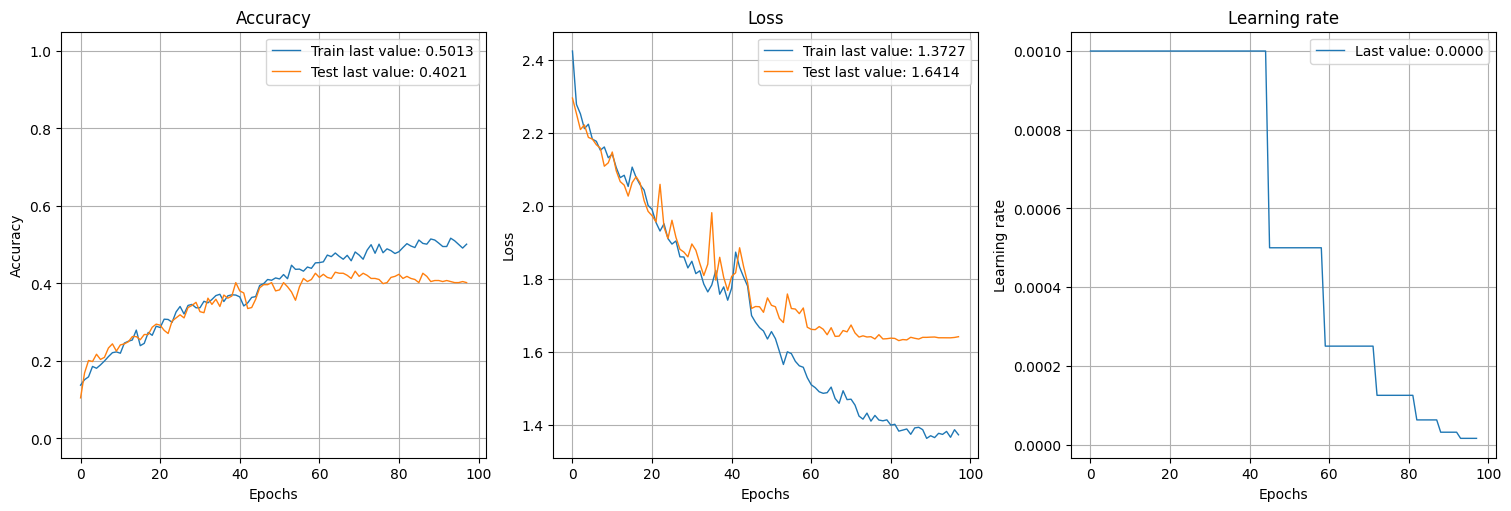

I0000 00:00:1730172214.354999   93819 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_56', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1730172214.375689   93831 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_57', 16 bytes spill stores, 16 bytes spill loads

I0000 00:00:1730172214.389075   93827 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4', 124 bytes spill stores, 124 bytes spill loads

I0000 00:00:1730172214.733224   93834 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1686', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1730172215.164830   93825 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1686', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1730172215.400272   93828 a

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 891ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


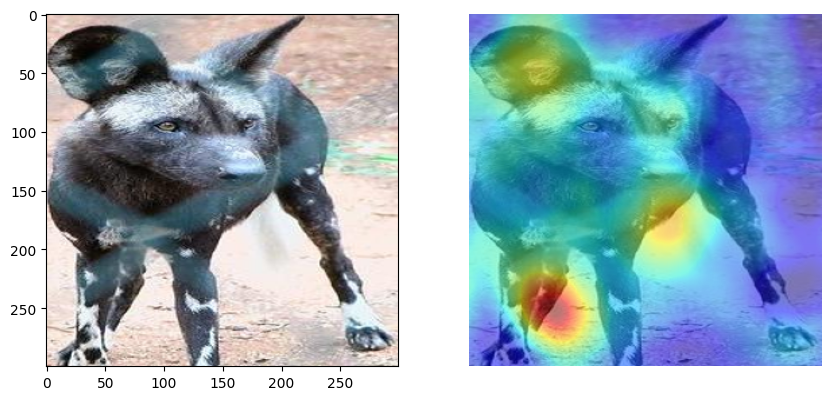

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


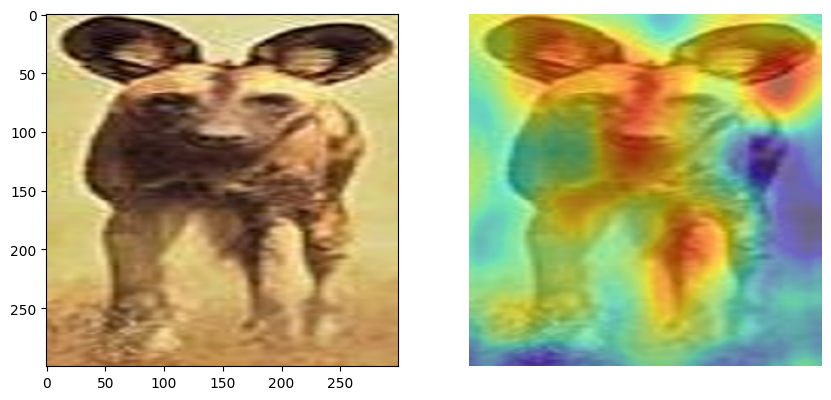

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


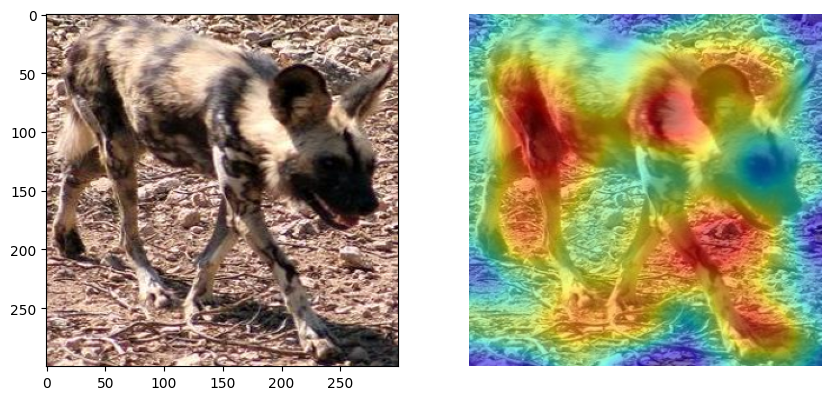

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


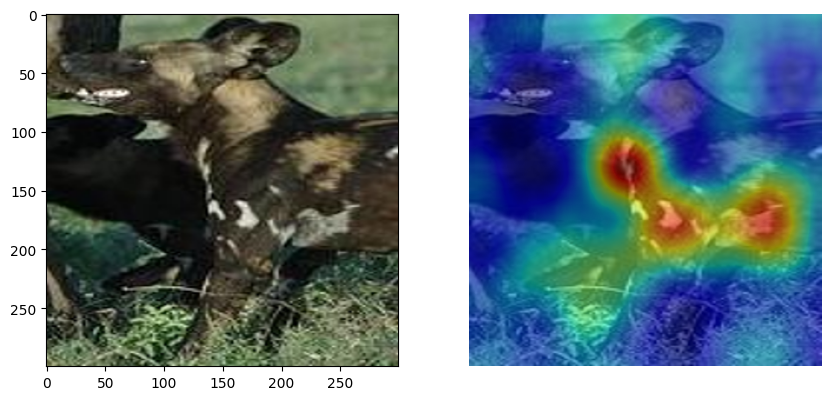


Starting training of cnn model.

Epoch 1/100


2024-10-29 10:25:10.703904: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_17_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-10-29 10:25:14.686024: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.81GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-29 10:25:17.800850: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.25GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-29 10:25:18.604680: W external/local_tsl/tsl/framework/bfc_allo

93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1826 - loss: 2.5730

2024-10-29 10:25:53.781497: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.17GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-29 10:25:54.012064: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-29 10:25:54.365695: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 384ms/step - accuracy: 0.1832 - loss: 2.5691 - val_accuracy: 0.1019 - val_loss: 10.5422 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - accuracy: 0.2194 - loss: 2.3071 - val_accuracy: 0.2440 - val_loss: 3.3247 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 346ms/step - accuracy: 0.2626 - loss: 2.1877 - val_accuracy: 0.1582 - val_loss: 3.3612 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.2367 - loss: 2.1779 - val_accuracy: 0.2520 - val_loss: 3.0027 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 346ms/step - accuracy: 0.2951 - loss: 1.9848 - val_accuracy: 0.2172 - val_loss: 2.7754 - learning_rate: 0.0010
Epoch 6/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - accuracy: 0.3114 - loss: 2.0206 - val_accuracy: 0.1823 - val_loss: 3.1689 - learning_rate: 0.0010
Epoch 7/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 345ms/step - accuracy: 0.2935 - loss: 2.0166

2024-10-29 11:17:32.815158: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Test Accuracy:0.7168900966644287.



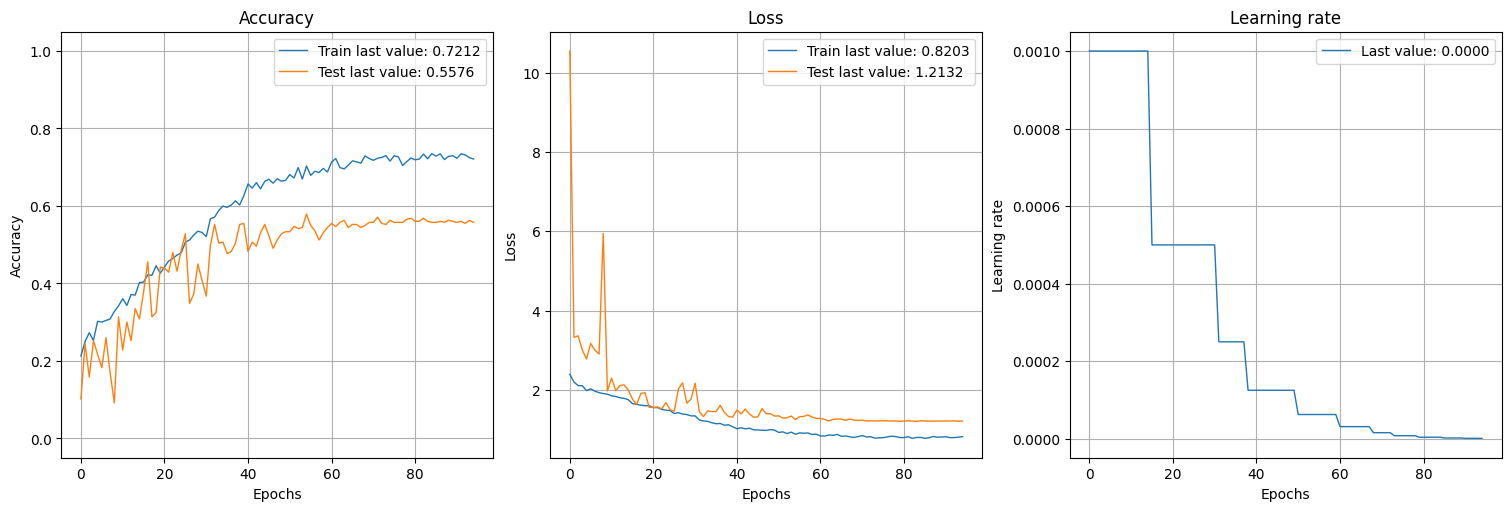

2024-10-29 11:17:44.531043: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.57GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-10-29 11:17:47.202250: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


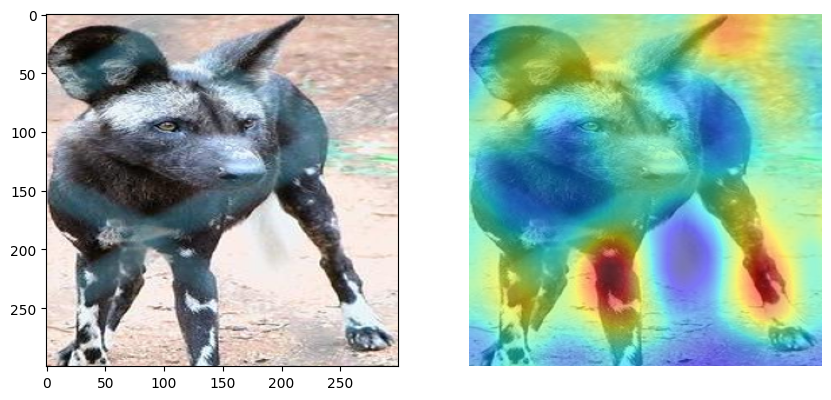

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


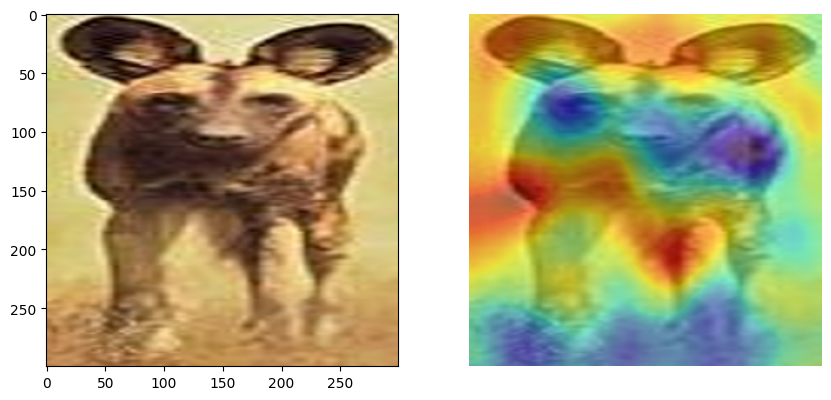

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step


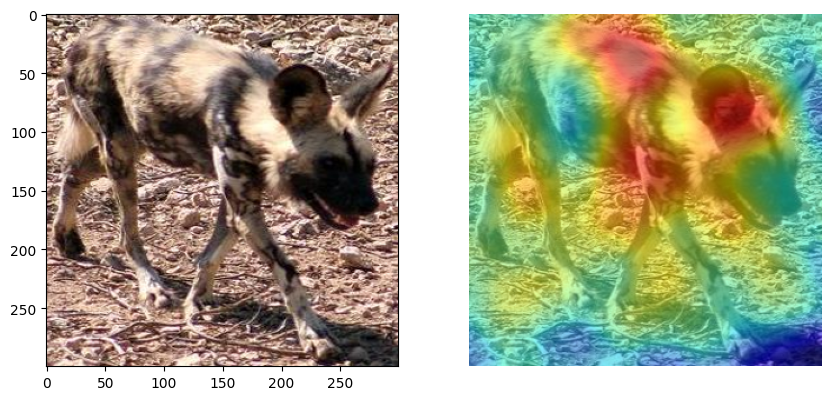

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step


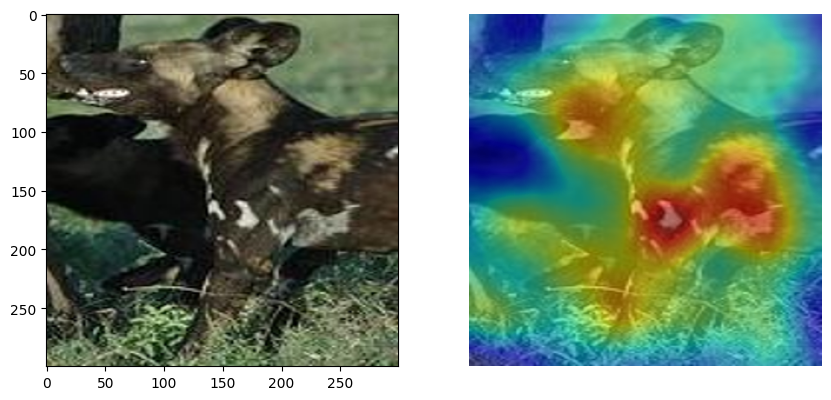

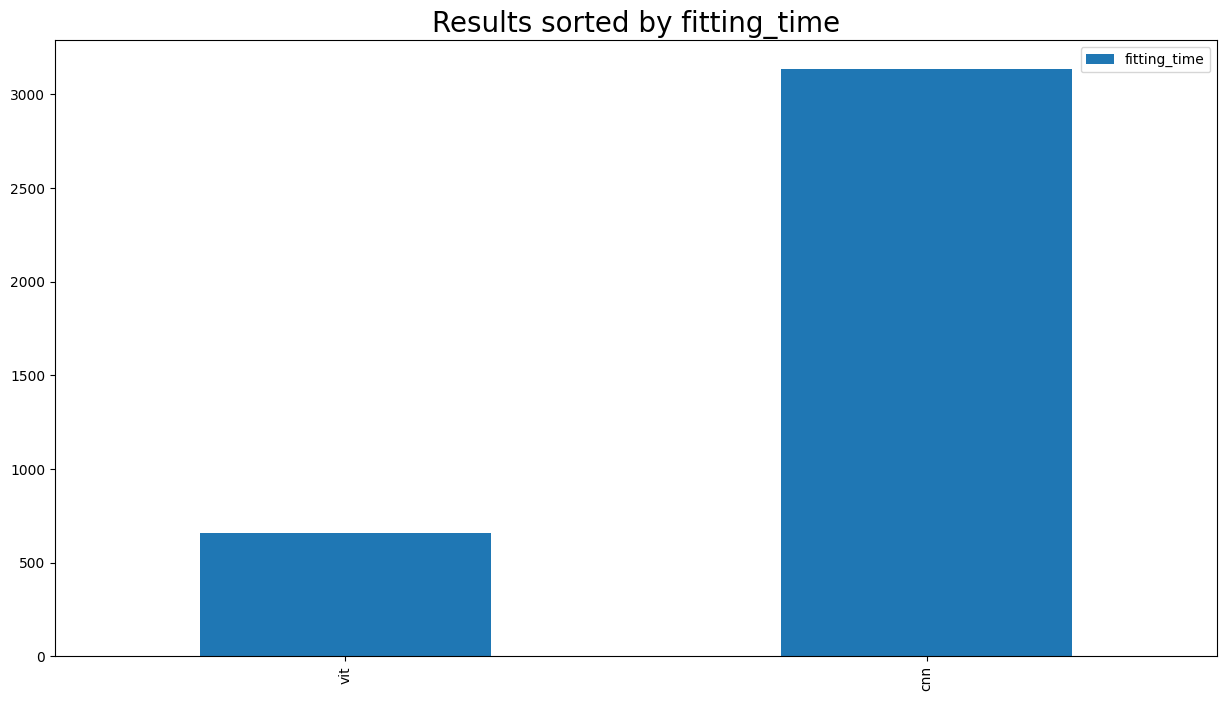

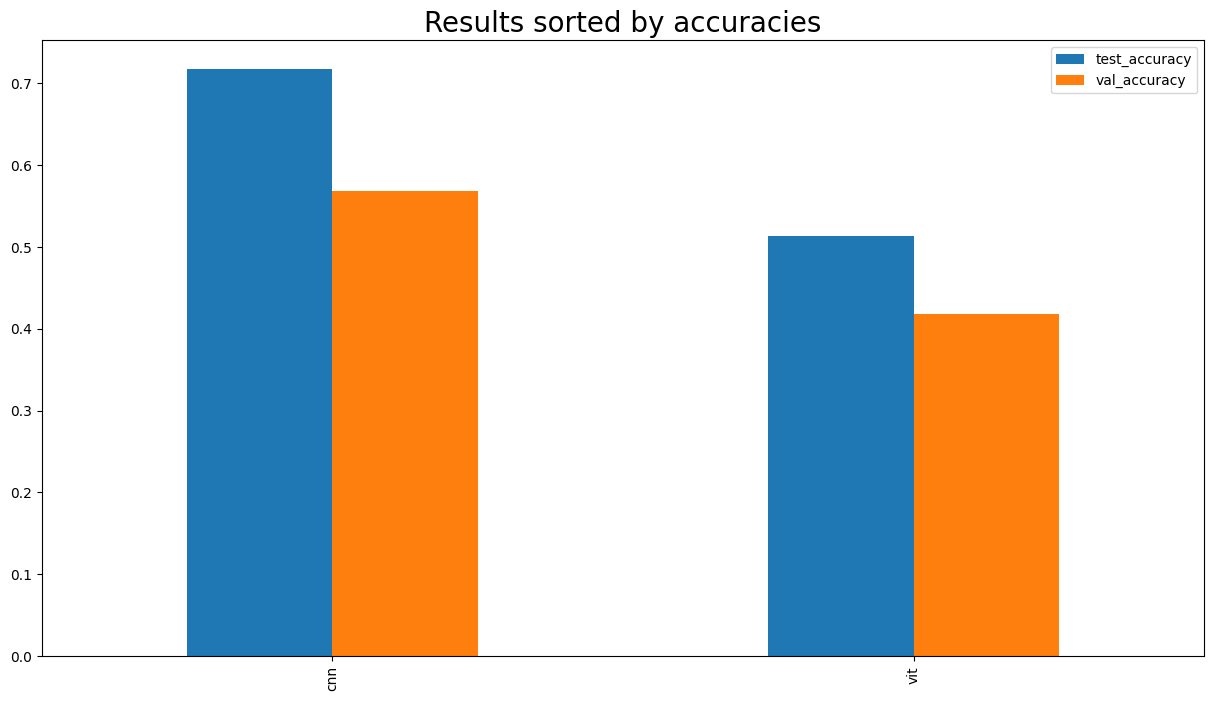

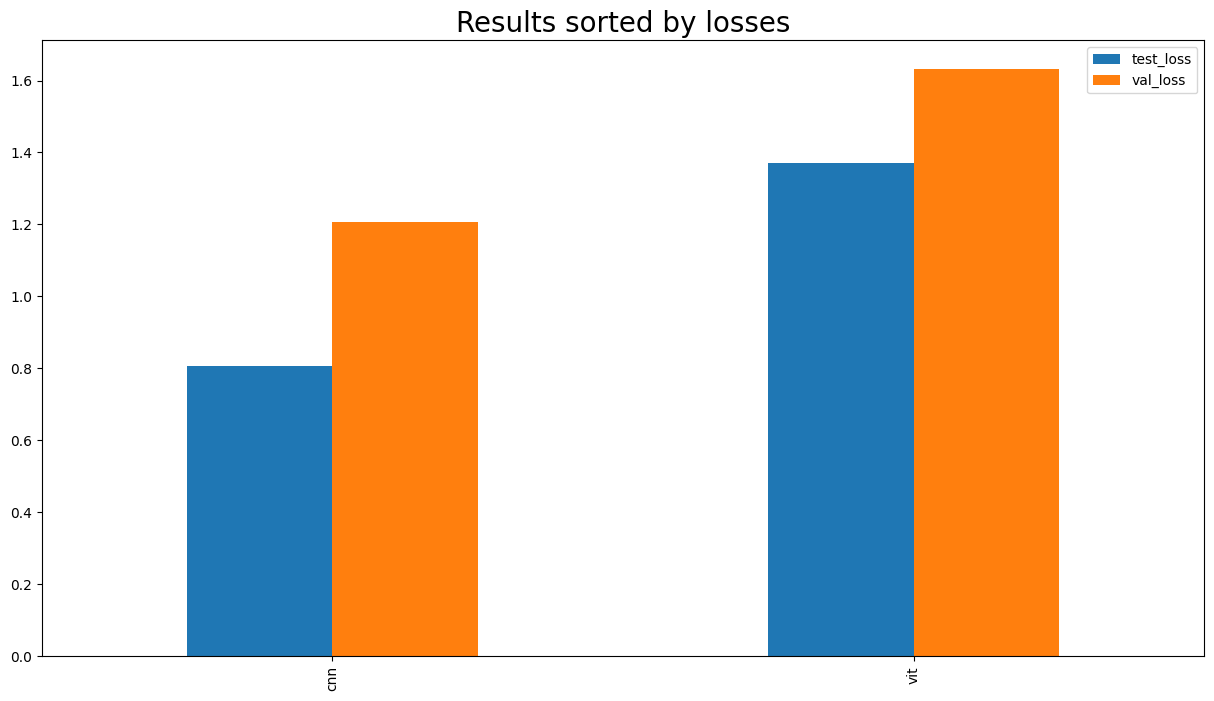

Custom models learning script finished.



In [16]:
print("Starting custom models learning script.\n")
remove_last_generated_models()

image_size = (300, 300)
batch_size = 16
labels_number = 10

dataset_train = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.2,
                            data_type='training')
dataset_val = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, validation_split=0.2,
                          data_type='validation')
dataset_test = get_dataset(CROPPED_IMAGES_PATH, image_size, batch_size, data_type=None)

random_row_ids_for_rise = [randint(0, len(dataset_test) - 1) for _ in range(4)]

results = []
for model_name in [
    "vit",
    "cnn"
]:
    print(f"\nStarting training of {model_name} model.\n")

    model = get_model(model_name, labels_number)

    result = get_results_of_model(model, dataset_train, dataset_val, dataset_test, model_name,
                                  batch_size=batch_size, epoch=100)
    results.append(result)

    model.save(f"{MODELS_PATH}/model_{model_name}.keras")

    explain_images(model, model_name, random_row_ids_for_rise, image_size)

sorted_results = sorted(results, key=lambda x: x["val_accuracy"], reverse=True)
display_results(sorted_results)

print("Custom models learning script finished.\n")